## Installs and Imports

In [1]:
%%capture
!pip install tqdm pyLDAvis gensim numpy bokeh contractions
!conda install -c conda-forge huggingface_hub -y

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import base64
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Data Acquisition via Gmail API

In [ ]:
from quickstart import get_service, get_data
service = get_service()
messages = get_data(service, 'Medium Daily Digest')

In [ ]:
print(len(messages))

In [ ]:
print(messages[0])

In [ ]:
# experimenting with a single message
message = messages[0]
msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
print(msg.keys())

In [ ]:
print(msg['snippet'])

In [ ]:
print(msg['payload']['parts'][0]['body']['data'][:200])

In [ ]:
content = msg['payload']['parts'][0]['body']['data']
msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
print(msg_body[:1500])

In [ ]:
text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)[:5]

### Regex Parsing of HTML Text

In [ ]:
def parse_email_digest(date, msg_body):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
    articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)]
    
    # workaround for old email Medium Daily Digest format prior to March 23, 2021
    if len(articles) == 0:
        articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n(.*) \r\n\ in (.*)\r\n(.*) min read', text, re.MULTILINE)]
    return articles

data = []
num_articles_fetched = []
for message in tqdm(messages):
    
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    
    # Get date of email for the purpose of topic modeling over time
    for date_dict in msg['payload']['headers']:
        if date_dict['name'] == 'Date':
            date = date_dict['value']
    date = pd.to_datetime(date)

    # Get the email body and decode it from UTF-8
    content = msg['payload']['parts'][0]['body']['data']
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    
    # Extract article information for all articles featured in daily digest
    fetched_articles = parse_email_digest(date, msg_body)
    num_articles_fetched.append(len(fetched_articles))
    for articles in fetched_articles:
        data.append([date, *articles])


In [ ]:
for entry in data[:3]:
    print(entry)

In [ ]:
# TROUBLESHOOT HERE
# identify all zero articles fetched digest emails
message = messages[num_articles_fetched.index(0)]
msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
for date_dict in msg['payload']['headers']:
    if date_dict['name'] == 'Date':
        date = date_dict['value']
date = pd.to_datetime(date)
content = msg['payload']['parts'][0]['body']['data']
msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
# print(text)

In [ ]:
df = pd.DataFrame(data, columns = ['Date', 'Title', 'Subtitle', 'Author', 'Publication', 'Minutes'])
df['Minutes'] = df['Minutes'].astype(int)
df.to_csv('raw_data/article_data_via_gmail_api.csv', index=False)
df

## Load Data from CSV

In [4]:
df = pd.read_csv('raw_data/article_data_via_gmail_api.csv')
df

,Date,Title,Subtitle,Author,Publication,Minutes
0,2021-08-30 11:40:00+00:00,Towards Better Data Visualizations and Graphics,Design principles for creating data-based graphics and visuals,Prashant Mudgal,Towards Data Science,5
1,2021-08-30 11:40:00+00:00,Making Sense of 33 Million Rows of Instacart Data: Exploratory Data Analysis…,Instacart is one of the hottest Silicon Valley startups of the last decade and is now valued at whopping $39…,Vijay Vankayalapati,Geek Culture,6
2,2021-08-30 11:40:00+00:00,Data Science Learning Path with Python,"I often receive messages from new members of Jakarta AI Research Discord Server, ""where do I start to learn…",Andreas Chandra,Data Folks Indonesia,3
3,2021-08-30 11:40:00+00:00,Jupyter Notebook can do that?,Soup up your cells with a couple of key extensions,Jesse Markowitz,CodeX,5
4,2021-08-30 11:40:00+00:00,Reshaping Mitochondria to Reverse Obesity,Changing the shape of mitochondria can reverse some of the molecular processes underlying obesity (in mice),Gunnar De Winter,In Fitness And In Health,4
...,...,...,...,...,...,...
9343,2020-01-01 16:30:00+00:00,How to Get the Unquantifiable Benefits of Cold Showers,The surprising side effects that science can't measure and money can't buy,May Pang,Better Humans,10
9344,2020-01-01 16:30:00+00:00,Screw Productivity Hacks: My Morning Routine Is Getting up Late,Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…,Jessica Valenti,GEN,3
9345,2020-01-01 16:30:00+00:00,The Latest Science on Chronic Pain Is Fascinating,"Experts can even predict who's likely to suffer or recover, based on brain structure and personality",Robert Roy Britt,Elemental,14
9346,2020-01-01 16:30:00+00:00,5 scientific myths you probably believe about the Universe,How a little knowledge can bring about some huge misconceptions… and how to fix it.,Ethan Siegel,Starts With A Bang!,8


## Quick Exploratory Visualizations

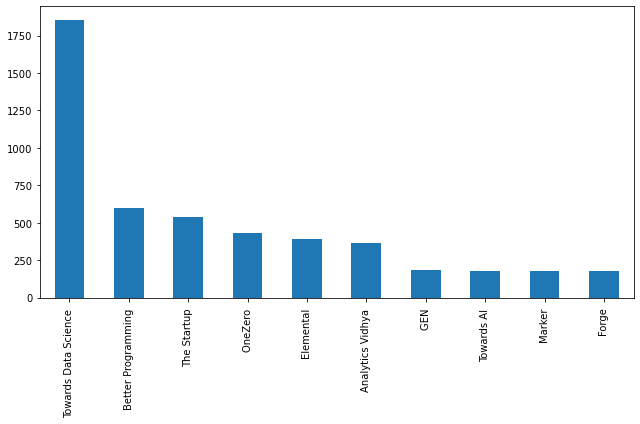

In [5]:
fig = plt.figure(figsize=(9,6))
df['Publication'].value_counts().iloc[:10].plot.bar();
plt.tight_layout();
fig.savefig('./figures/publication_counts.png')

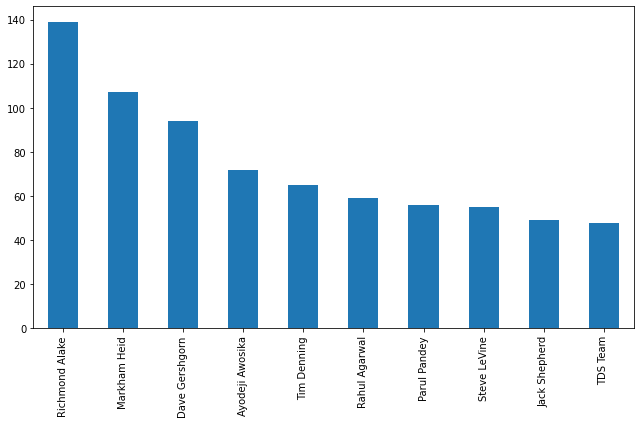

In [6]:
fig = plt.figure(figsize=(9,6))
df['Author'].value_counts().iloc[:10].plot.bar();
plt.tight_layout();
fig.savefig('./figures/author_counts.png')

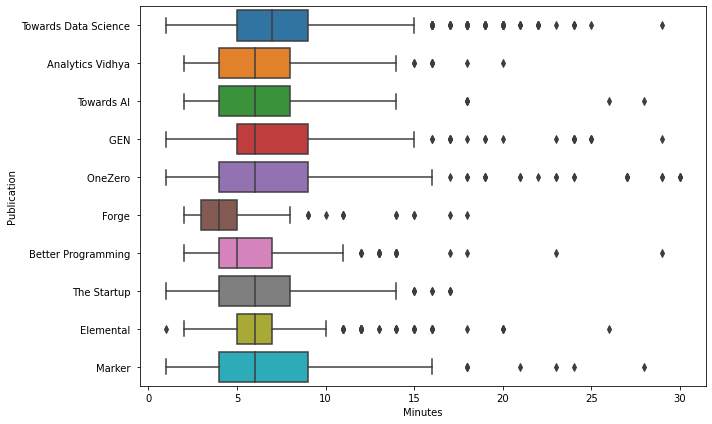

In [7]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.boxplot(data=df[(df['Minutes'] <= 30) & (df['Publication'].isin(df['Publication'].value_counts().iloc[:10].index))], x='Minutes', y='Publication')
plt.tight_layout()
fig.savefig('./figures/minutes_publication_boxplot.png')

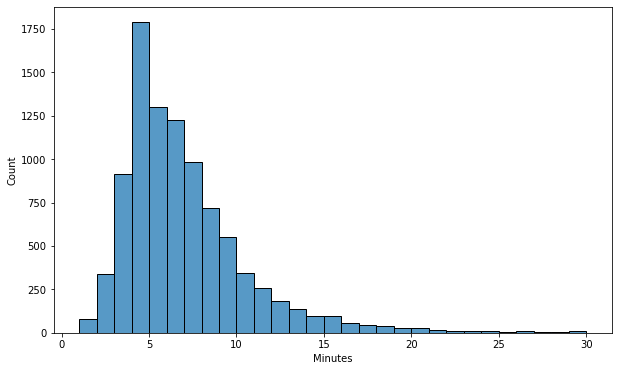

In [8]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.histplot(data=df[(df['Minutes'] <= 30)], x='Minutes', binwidth=1)
fig.savefig('./figures/minutes_distribution.png')

## Cleaning & Preprocessing

In [94]:
# Gensim and LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# NLP stuff
import contractions
import demoji
import string
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nltk.download('wordnet')
import spacy

# Plotting tools
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
from sklearn.manifold import TSNE
from pprint import pprint

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def preprocess(text_col):
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # remove emojis
    text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # fix contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in nltk.corpus.stopwords.words('english') if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

df['text'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)
df['text'] = preprocess(df['text'])
df.rename(columns={'Date': 'date'}, inplace=True)
df[['date', 'text']].to_csv('medium-suggested-cleaned.csv', index=False)
print(*df['text'].head(20).values, sep='\n')

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


towards better data visualization graphic design principle creating databased graphic visuals
making sense million row instacart data exploratory data analysis instacart one hottest silicon valley startup last decade valued whopping
data science learning path python often receive message new member jakarta research discord server start learn
jupyter notebook soup cell couple key extension
reshaping mitochondrion reverse obesity changing shape mitochondrion reverse molecular process underlying obesity mouse
data type data science quick guide difference quantitative qualitative data
reducing product stockouts hypermarket time series modeling pragmatic guide creating data science product limited data high business constraint
summarize article using nlp summarize text using simple technique
tim ferriss system mastering skill pure genius method world successful human guinea pig
datasets need practice data science skill make great great collection different kind datasets
python package moder

## Wordcloud

In [11]:
all_words = ' '.join(df['text'].values).split()
all_words[:20]

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['towards',
 'better',
 'data',
 'visualization',
 'graphic',
 'design',
 'principle',
 'creating',
 'databased',
 'graphic',
 'visuals',
 'making',
 'sense',
 'million',
 'row',
 'instacart',
 'data',
 'exploratory',
 'data',
 'analysis']

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


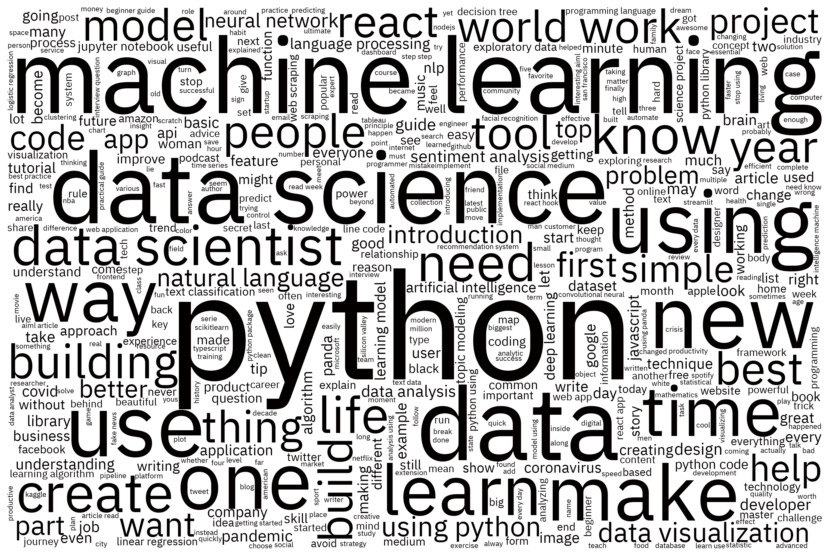

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Regular.ttf', 
                      background_color="white", width=3000, height=2000, collocations=True,
                      max_words=500, stopwords=STOPWORDS).generate_from_text(' '.join(df['text'].values))

# set the word color to black
wordcloud.recolor(color_func = black_color_func)
fig = plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
fig.savefig('./figures/wordcloud.png')

## Topic Modeling Prep

### Data Preprocessing

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['text'].tolist()))
print(data_words[:1])
print("Total docs:", len(data_words))

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['towards', 'better', 'data', 'visualization', 'graphic', 'design', 'principle', 'creating', 'databased', 'graphic', 'visuals']]
Total docs: 9348


In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['well', 'graphic', 'design', 'principle', 'create', 'database', 'graphic', 'visual']]


### Lemmatization

In [17]:
# Create dictionary and corpus needed for topic modeling

# dictionary is a mapping of word_id --> word, as the variable name implies
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# the preprocessed and lemmatized documents themselves
texts = data_lemmatized

# corpus is a mapping of word_id --> word frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('create', 1),
  ('database', 1),
  ('design', 1),
  ('principle', 1),
  ('visual', 1),
  ('well', 1)]]

## Latent Dirichlet Allocation (LDA)

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Print the Keyword in the 10 topics
pprint(lda_model.show_topics(formatted=False)[:5])
doc_lda = lda_model[corpus]

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('people', 0.09273163),
   ('question', 0.066632375),
   ('skill', 0.042392056),
   ('understand', 0.03706378),
   ('see', 0.035146777),
   ('answer', 0.030629925),
   ('little', 0.029270545),
   ('home', 0.024758924),
   ('end', 0.024424402),
   ('explain', 0.02363316)]),
 (1,
  [('make', 0.096967615),
   ('life', 0.07183768),
   ('know', 0.06467543),
   ('work', 0.061228447),
   ('way', 0.052680302),
   ('become', 0.037998095),
   ('world', 0.025656857),
   ('productivity', 0.023097994),
   ('woman', 0.020656427),
   ('black', 0.02023665)]),
 (2,
  [('learn', 0.16194253),
   ('machine', 0.10378466),
   ('programming', 0.045684822),
   ('javascript', 0.0430601),
   ('let', 0.037853964),
   ('predict', 0.025627408),
   ('programmer', 0.023802122),
   ('never', 0.022433423),
   ('secret', 0.022118794),
   ('relationship', 0.021739144)]),
 (3,
  [('thing', 0.07279112),
   ('build', 0.04359416),
   ('tip', 0.038880512),
   ('learning', 0.03860536),
   ('job', 0.037250806),
   ('to

### Model Evaluation Metrics

In [21]:
from gensim.models import CoherenceModel

# Compute Perplexity (lower is better)
print('Perplexity: ', round(lda_model.log_perplexity(corpus), 2))

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  -6.61
Coherence Score:  0.39


### Visualize Keywords

In [22]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(lda_model.num_topics))
viz_prep = True
if viz_prep:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(lda_model.num_topics) +'.html')
LDAvis_prepared

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.039881  0.122766  1       1        13.573808
5      0.144716 -0.423659  2       1        13.116825
1     -0.444871 -0.093408  3       1        11.242512
7      0.037188  0.062649  4       1        10.064983
8      0.039266  0.076904  5       1        9.907267 
4      0.037847  0.073611  6       1        9.634227 
6      0.038003  0.071081  7       1        9.162519 
3      0.037500  0.063445  8       1        9.015017 
2      0.035365  0.029475  9       1        7.684175 
0      0.035106  0.017134  10      1        6.598669 , topic_info=       Term         Freq        Total Category  logprob  loglift
48   use     1638.000000  1638.000000  Default  30.0000  30.0000
8    datum   1131.000000  1131.000000  Default  29.0000  29.0000
18   learn   856.000000   856.000000   Default  28.0000  28.0000
72   code    742.000000   742.000000   Default  27.0000  27.0000
13   make    750.000000   750.000000   Default  26.0000  26.0000
..    ...           ...          ...       ...      ...      ...
477  teach   59.402378    60.348382    Topic10 -4.3355   2.7025 
51   method  55.111809    56.057747    Topic10 -4.4105   2.7013 
192  fit     53.918876    54.865022    Topic10 -4.4324   2.7009 
191  eat     53.019215    53.965185    Topic10 -4.4492   2.7006 
727  care    51.283992    52.230057    Topic10 -4.4825   2.7000 

[330 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
327   9      0.987452  actually
684   5      0.994584  advice  
507   5      0.991935  also    
6     1      0.996711  analysis
448   10     0.993644  answer  
...  ..           ...       ...
71    3      0.997541  work    
55    3      0.993731  world   
78    4      0.996221  write   
109   2      0.996128  year    
333   7      0.987889  young   

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 2, 8, 9, 5, 7, 4, 3, 1])

## LDA Mallet Model

In [41]:
mallet_path = '~/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [42]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False)[:3])

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score: ', round(coherence_ldamallet, 2))

[(0,
  [('good', 0.06513730743469524),
   ('year', 0.05291359678499665),
   ('design', 0.04370395177494977),
   ('start', 0.034996651038178166),
   ('big', 0.02896851975887475),
   ('question', 0.027628935030140658),
   ('stop', 0.025619557937039517),
   ('interview', 0.024447421299397188),
   ('job', 0.02344273275284662),
   ('medium', 0.021098459477561955)]),
 (1,
  [('create', 0.08794137241838774),
   ('build', 0.06795469686875416),
   ('react', 0.06728847435043304),
   ('guide', 0.06628914057295136),
   ('app', 0.05346435709526982),
   ('web', 0.04746835443037975),
   ('application', 0.03231179213857428),
   ('javascript', 0.029313790806129246),
   ('website', 0.01882078614257162),
   ('deploy', 0.018654230512991338)]),
 (2,
  [('datum', 0.24925323597743113),
   ('science', 0.11251244606704282),
   ('data', 0.08894789246598075),
   ('analysis', 0.05127779621639562),
   ('visualization', 0.04961832061068702),
   ('scientist', 0.04779289744440757),
   ('library', 0.03816793893129771)

In [44]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Find most optimal number of topics

In [45]:
# NOTE: can take a long time to run...
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=40, step=4)

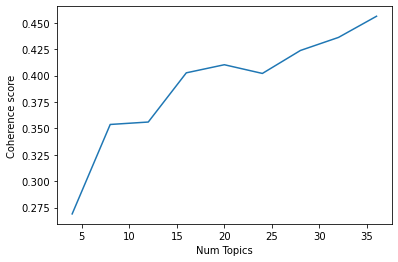

In [46]:
# Graph coherence values vs number of topics
limit=40; start=4; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [47]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.269
Num Topics = 8  has Coherence Value of 0.3537
Num Topics = 12  has Coherence Value of 0.356
Num Topics = 16  has Coherence Value of 0.4026
Num Topics = 20  has Coherence Value of 0.4103
Num Topics = 24  has Coherence Value of 0.402
Num Topics = 28  has Coherence Value of 0.4238
Num Topics = 32  has Coherence Value of 0.4361
Num Topics = 36  has Coherence Value of 0.4562


In [54]:
# optimal_model = model_list[coherence_values.index(max(coherence_values))]
optimal_model = model_list[-5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.467*"datum" + 0.211*"science" + 0.102*"project" + 0.096*"analysis" + '
  '0.025*"exploratory" + 0.013*"essential" + 0.010*"journey" + '
  '0.009*"preprocesse" + 0.008*"strong" + 0.007*"insight"'),
 (1,
  '0.107*"life" + 0.067*"change" + 0.046*"brain" + 0.044*"improve" + '
  '0.039*"feel" + 0.033*"habit" + 0.027*"real" + 0.025*"back" + '
  '0.022*"productivity" + 0.021*"strategy"'),
 (2,
  '0.183*"data" + 0.097*"scientist" + 0.055*"question" + 0.049*"interview" + '
  '0.048*"job" + 0.041*"skill" + 0.036*"business" + 0.026*"answer" + '
  '0.024*"engineer" + 0.022*"hard"'),
 (3,
  '0.090*"understand" + 0.071*"problem" + 0.059*"deep" + 0.036*"implement" + '
  '0.034*"power" + 0.032*"system" + 0.031*"type" + 0.028*"challenge" + '
  '0.025*"solve" + 0.022*"relationship"'),
 (4,
  '0.089*"tool" + 0.071*"top" + 0.070*"developer" + 0.052*"processing" + '
  '0.049*"natural_language" + 0.045*"technique" + 0.040*"fast" + 0.038*"list" '
  '+ 0.037*"development" + 0.037*"framework"'),
 (5,

### Finding the dominant topic in each sentence

In [70]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    sent_topics_df['Dominant_Topic'] = sent_topics_df['Dominant_Topic'].astype(int)

    # Add original text to the end of the output
    contents = pd.Series([" ".join(text) for text in texts])
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.0636,"understand, problem, deep, implement, power, system, type, challenge, solve, relationship",well graphic design principle create database graphic visual
1,1,0,0.0917,"datum, science, project, analysis, exploratory, essential, journey, preprocesse, strong, insight",make sense row instacart data exploratory datum analysis instacart hot startup last decade value whopping
2,2,8,0.0887,"part, start, find, stop, live, music, idea, run, plot, podcast",datum science learn path often receive message new member start learn
3,3,10,0.0639,"code, write, tutorial, tip, line, twitter, scrape, sentiment_analysis, quick, review",soup cell couple key extension
4,4,1,0.0660,"life, change, brain, improve, feel, habit, real, back, productivity, strategy",reshape mitochondrion reverse obesity change shape mitochondrion reverse molecular process underlie obesity mouse
5,5,0,0.0948,"datum, science, project, analysis, exploratory, essential, journey, preprocesse, strong, insight",datum type data science quick guide difference quantitative qualitative datum
6,6,0,0.0873,"datum, science, project, analysis, exploratory, essential, journey, preprocesse, strong, insight",reduce product stockout hypermarket time series model pragmatic guide create datum science product limit datum high business constraint
7,7,19,0.1316,"text, article, nlp, classification, read, book, word, week, process, task",summarize article use nlp summarize text use simple technique
8,8,2,0.0750,"data, scientist, question, interview, job, skill, business, answer, engineer, hard",tim_ferriss system master skill pure genius method world successful human guinea pig
9,9,15,0.0902,"work, design, day, great, product, trend, research, human, break, designer",dataset need practice datum science skill make great great collection different kind dataset


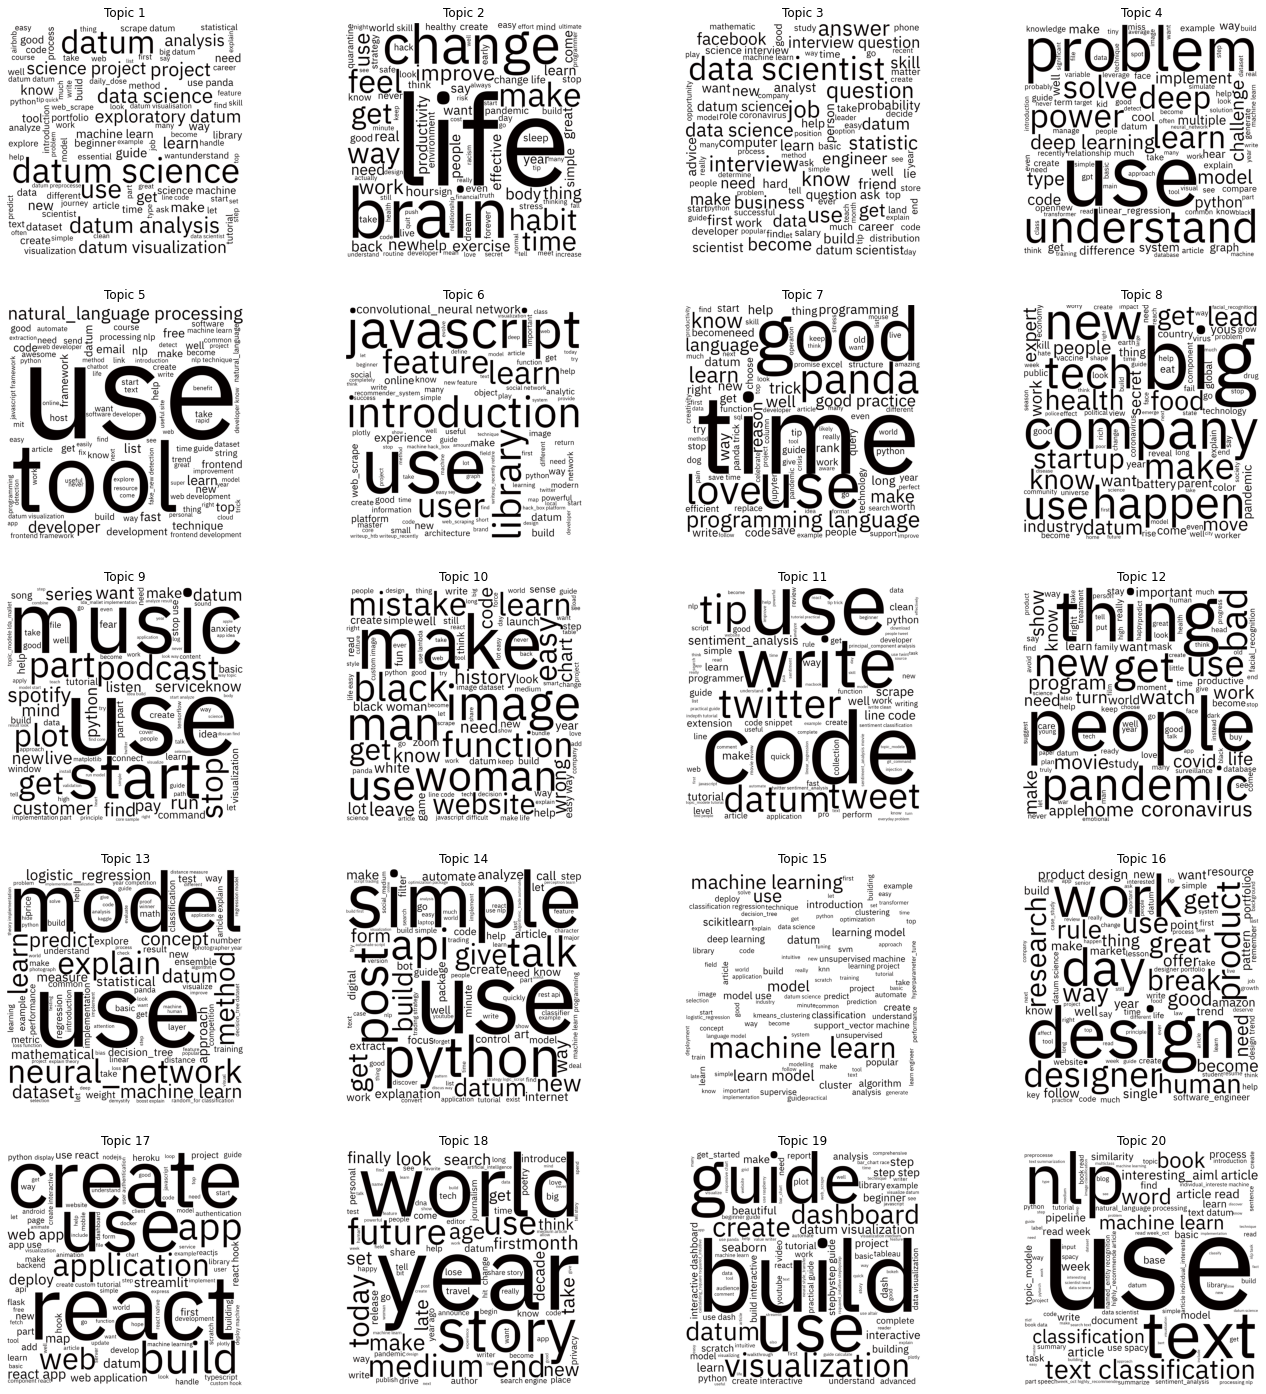

In [90]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

num_topics = optimal_model.num_topics
fig, ax = plt.subplots(num_topics // 4, int(num_topics / (num_topics // 4)), figsize=(20, 20))
for i in range(num_topics):
    text = ' '.join(df_dominant_topic.loc[df_dominant_topic['Dominant_Topic']==i, 'Text'].values)    
    wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Regular.ttf', 
                      background_color="white", width=2000, height=2000, max_words=100, random_state=42, 
                      collocations=True, stopwords=stop_words, ).generate(text)
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)
    ax[i // 4, i % 4].imshow(wordcloud) 
    ax[i // 4, i % 4].set_title(f"Topic {i+1}")
    # No axis details
    ax[i // 4, i % 4].axis("off");
    
plt.tight_layout(pad=3);
fig.savefig('figures/topic_wordclouds.png')

### Find the most representative document for each topic

In [83]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(optimal_model.num_topics)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.2385,"datum, science, project, analysis, exploratory, essential, journey, preprocesse, strong, insight",datum preprocesse exploratory datum analysis datum science use different datum preprocesse exploratory datum analysis eda technique prepare datum
1,1,0.2266,"life, change, brain, improve, feel, habit, real, back, productivity, strategy",stress brain fall back old habit effort save energy cognitive resource stress brain prioritize old habit routine
2,2,0.1742,"data, scientist, question, interview, job, skill, business, answer, engineer, hard",interview uber junior dev phone interview technical question recently speak junior web developer tough time uber phone interview think
3,3,0.1490,"understand, problem, deep, implement, power, system, type, challenge, solve, relationship",understand term machine learn visually visual challenge recently participate visual challenge part task phase machine learn
4,4,0.1685,"tool, top, developer, processing, natural_language, technique, fast, list, development, framework",mustuse tool frontend development list helpful tool personally use recommend frontend development
5,5,0.1557,"library, introduction, javascript, feature, user, network, experience, online, master, powerful",awesome small javascript library try show rather unknown powerful small javascript library make life
6,6,0.1639,"good, time, panda, programming, language, love, trick, practice, long, reason",panda method help replace excel use panda method transition excel save serious time
7,7,0.1692,"big, company, tech, happen, industry, health, move, startup, component, lead",datum science public health factor great impact life multivariate linear_regression analysis public health factor influence global life expectancy
8,8,0.1917,"part, start, find, stop, live, music, idea, run, plot, podcast",plot current fire tutorial cover geospacial command plot current fire fire
9,9,0.1466,"make, easy, image, function, website, woman, black, chart, lot, man",stallion deserve world protect black woman many black woman suffer silence protect other remain unprotected


In [84]:
# Number of Documents for Each Topic
topic_df = pd.DataFrame(df_topic_sents_keywords['Dominant_Topic'].value_counts())   
topic_df.reset_index(inplace=True)
topic_df.columns = ['Dominant_Topic', 'Num_Documents']

# Percentage of Documents for Each Topic
topic_df['Perc_Documents'] = topic_df['Num_Documents'].apply(lambda x: round(x/topic_df['Num_Documents'].values.sum(), 4))

# Merge with other df containing keywords for each topic
topic_df = topic_df.merge(sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']], 
                          left_on='Dominant_Topic', right_on='Topic_Num', how='left').drop(columns=['Topic_Num'])

topic_df

,Dominant_Topic,Num_Documents,Perc_Documents,Keywords
0,0,812,0.0869,"datum, science, project, analysis, exploratory, essential, journey, preprocesse, strong, insight"
1,1,744,0.0796,"life, change, brain, improve, feel, habit, real, back, productivity, strategy"
2,7,575,0.0615,"big, company, tech, happen, industry, health, move, startup, component, lead"
3,2,547,0.0585,"data, scientist, question, interview, job, skill, business, answer, engineer, hard"
4,3,500,0.0535,"understand, problem, deep, implement, power, system, type, challenge, solve, relationship"
5,6,482,0.0516,"good, time, panda, programming, language, love, trick, practice, long, reason"
6,16,477,0.0510,"create, react, app, web, application, deploy, build, map, hook, custom"
7,4,466,0.0499,"tool, top, developer, processing, natural_language, technique, fast, list, development, framework"
8,5,441,0.0472,"library, introduction, javascript, feature, user, network, experience, online, master, powerful"
9,11,434,0.0464,"people, thing, pandemic, show, bad, home, coronavirus, turn, movie, program"


### Visualization

In [88]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9348 samples in 0.011s...
[t-SNE] Computed neighbors for 9348 samples in 1.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9348
[t-SNE] Computed conditional probabilities for sample 2000 / 9348
[t-SNE] Computed conditional probabilities for sample 3000 / 9348
[t-SNE] Computed conditional probabilities for sample 4000 / 9348
[t-SNE] Computed conditional probabilities for sample 5000 / 9348
[t-SNE] Computed conditional probabilities for sample 6000 / 9348
[t-SNE] Computed conditional probabilities for sample 7000 / 9348
[t-SNE] Computed conditional probabilities for sample 8000 / 9348
[t-SNE] Computed conditional probabilities for sample 9000 / 9348
[t-SNE] Computed conditional probabilities for sample 9348 / 9348
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.661285
[t-SNE] KL divergence after 1000 iterations: 2.058626


In [95]:
# Plot the Topic Clusters using Bokeh

output_notebook()
n_topics = lda_model.num_topics
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...